# Back Testing Vectorizado

El backtesting es una parte esencial del trading. Es importante comprender el comportamiento de nuestra estrategia en el pasado para poder considerar como nos manejaremos en el futuro

Es importante tener en mente conceptos como:


*   Coeficiente de Sortino
*   Beta
*   Alfa





In [ ]:
!pip install yfinance --upgrade --no-cache-dir
!pip install ta

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import ta
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from matplotlib import cycler
#### Para nuestro panel
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

In [3]:
### Creamos nuestra función RSI
def RSI(val, neutral, window):
  """
        ------------------------------------------------------------------------------
        | Output: La función da los rendimientos de la estrategia RSI                |
        ------------------------------------------------------------------------------
        | Inputs: -val (type dataframe pandas): Valores de entrada de la acción      |
        |         -neutral (float): Valor neutral, es decir, zona de no acción       |
        |         -window (float): período de balanceo para el RSI                   |
        ------------------------------------------------------------------------------
  """

  # Imprime error si no encuentra la columna 'Adj Close'
  if "Adj Close" not in val.columns:
    ValueError("Necesitamos tener un nombre de columna Adj Close porque todos los cálculos se refieren a esta columna")

  val["rsi"] = ta.momentum.RSIIndicator(val["Adj Close"], window=window).rsi()



  """Señal de compra en largo """
  # Colocamos el umbral
  overbuy = 70
  neutral_buy = 50 + neutral

  # Poner valores nan para las columnas de la señal larga
  val["signal_long"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # Necesitamos definir la señal de apertura en largo (RSI ayer<55 y RSI hoy>55)
  val.loc[(val["rsi"]>neutral_buy) & (val["yersteday_rsi"]<neutral_buy), "signal_long"] = 1

  # Necesitamos definir la señal cierre en largo (RSI ayer>55 y RSI hoy<55) Señal falsa
  val.loc[(val["rsi"]<neutral_buy)&(val["yersteday_rsi"]>neutral_buy), "signal_long"] = 0

  # Necesitamos definir la señal cierre en largo (RSI ayer<70 y RSI hoy>70) Señal de sobrecompra
  val.loc[(val["rsi"]>overbuy)&(val["yersteday_rsi"]<overbuy), "signal_long"] = 0



  """Señal de venta en corto """
  # Colocamos el umbral
  oversell = 30
  neutral_sell = 50 - neutral

  # Poner valores nan para las columnas de la señal larga
  val["signal_short"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # Necesitamos definir la señal de apertura en corto (RSI ayer>45 y RSI hoy<45)
  val.loc[(val["rsi"]<neutral_sell) & (val["yersteday_rsi"]>neutral_sell), "signal_short"] = -1

  # Necesitamos definir la señal de cierre en corto (RSI ayer<45 y RSI hoy>45) Señal falsa
  val.loc[(val["rsi"]>neutral_sell)&(val["yersteday_rsi"]<neutral_sell), "signal_short"] = 0

  # Necesitamos definir la señal de cierre en corto (RSI ayer>30 y RSI hoy<30) Señal de sobre venta
  val.loc[(val["rsi"]<oversell)&(val["yersteday_rsi"]>oversell), "signal_short"] = 0

  """Calcular el retorno """
  # Calculamos el porcentaje de variación del activo
  val["pct"] = val["Adj Close"].pct_change(1)

  # Calculamos las posiciones
  val["Position"] = (val["signal_short"].fillna(method="ffill")+ val["signal_long"].fillna(method="ffill"))

  # Calculamos el valor de retorno de la estrategia
  val["return"] = val["pct"]*(val["Position"].shift(1))

  return val["return"] if isinstance(val["return"], pd.Series) else val["return"].squeeze()


# 1: Sortino Beta Alpha

###### Sortino
El índice de Sortino es una estadística similar al índice de Sharpe con la misma interpretación. Sin embargo, el cálculo es ligeramente diferente. En efecto, en el índice de Sortino sólo se tiene en cuenta la volatilidad de las ganancias negativas porque es lo que tememos y no las ganancias alcistas que nos hacen ganar dinero. <br>
<p align="center">
$Sortino = \frac{\mu }{\sigma_{down}}$
<p> <br>

* SortinoRatio < 0 : Inversión no rentable porque las ganancias son negativas.
* SortinoRatio < 1: Inversión rentable, pero el riesgo de la inversión es mayor que la rentabilidad.
* SortinoRatio > 1: Inversión muy rentable porque el riesgo es menor que el rendimiento.


In [4]:
# Carga sin jerarquía
f = yf.download("NVDA", auto_adjust=False, end="2025-05-09")[["Adj Close"]]
f.columns = ["Adj Close"]

# Ejecuta RSI y garantiza formato Serie
return_serie = RSI(f, 5, 14)
return_serie = pd.Series(return_serie.values, index=return_serie.index, name="return")

# Calcular Sortino
mean = np.mean(return_serie)
vol = np.std(return_serie[return_serie < 0])
sortino = np.sqrt(252) * mean / vol

# Imprimir
print(f"Sortino: {'%.3f' % sortino}")


[*********************100%***********************]  1 of 1 completed

Sortino: 0.434


###### Beta
La beta es un estadístico que indica la relación entre las variaciones de nuestra cartera y las del mercado que está representado por un índice (por ejemplo el SP500). <br>

<p align="center">
$Beta = \frac{Cov(r_{M},r_{PF}) }{Var(r_{M})}$
<p> <br>



* abs(Beta) < 1: Es bueno porque significa que la cartera tiene una variación menor que el índice. (Si beta=0,9 significa que si el índice varía en 1 la cartera varía en 0,9)
* abs(Beta) > 1: No es bueno porque significa que slau cartera tiene una variación mayor que el índice. (Si beta=1,1 significa que si el índice varía de 1 la cartera varía en 1,1)

*abs(-x) = x = abs(x) (abs da sólo el valor de la variable no el signo)*

In [5]:
# Necesitamos calcular la covarianza entre el mercado y la cartera
sp500 = yf.download("^GSPC",auto_adjust=False)["Adj Close"].pct_change(1)
sp500.name = "SP500"

# Los concatenamos para hacer las covarianzas
val = pd.concat((return_serie, sp500), axis=1).dropna()
val

[*********************100%***********************]  1 of 1 completed


,return,^GSPC
Date,,
1999-02-16,0.005978,0.009544
1999-02-17,-0.053577,-0.014365
1999-02-18,0.000000,0.010825
1999-02-19,0.000000,0.001568
1999-02-22,0.005978,0.026565
...,...,...
2025-05-02,0.000000,0.014727
2025-05-05,-0.005939,-0.006382
2025-05-06,-0.002460,-0.007693


In [6]:
# Calculamos la matriz de covarianzas
cov_var_mat = np.cov(val.values, rowvar=False)
cov_var_mat

array([[ 5.42554839e-04, -3.27835568e-05],
       [-3.27835568e-05,  1.50249336e-04]])

In [7]:
# Calculamos beta
cov = cov_var_mat[0][1]
var = cov_var_mat[1][1]

beta = cov/var

print(f"Beta: {'%.3f' % beta}")

Beta: -0.218


###### **Alpha**
El alfa es una estadístico que indica si la cartera supera al mercado en términos de rentabilidad del riesgo. <br>

<p align="center">
$Alpha = r_{PF} - \beta*(r_{PF} - r_{f}) - r_{f}$
<p> <br>


* alfa > 0: La cartera supera al mercado en términos de rentabilidad del riesgo
* alfa < 0: la cartera tiene un rendimiento inferior al del mercado en términos de riesgo-rendimiento


In [8]:
# Calculamos alpha
alpha = (252 * mean * (1-beta))*100
print(f"Alpha: {'%.1f' % alpha} %")

Alpha: 20.6 %


## **2: Drawdown**

El drawdown (reducción) es una medida del riesgo de la estrategia. Una estadística interesante para conocer el rendimiento del algoritmo es el drawdown máximo. En efecto, representa la pérdida máxima de una estrategia durante un período de tiempo que nos permite comprender si la estrategia es arriesgada y, por tanto, elegirla en función de nuestro nivel de aversión al riesgo.

In [9]:
def drawdown_function(serie):

  # Calculamos la suma de los rendimientos
  cum = serie.dropna().cumsum() + 1

  # Calculamos el máximo de la suma en el período (máximo acumulado) # (1,3,5,3,1) --> (1,3,5,5,5)
  running_max = np.maximum.accumulate(cum)

  # Calculamos el drawdown
  drawdown = cum/running_max - 1
  return drawdown

In [10]:
# Calculamos el drawdown
drawdown = drawdown_function(return_serie)
drawdown

,return
Date,
1999-02-16,0.000000
1999-02-17,-0.053259
1999-02-18,-0.053259
1999-02-19,-0.053259
1999-02-22,-0.047316
...,...
2025-05-02,-0.074022
2025-05-05,-0.075036
2025-05-06,-0.075456


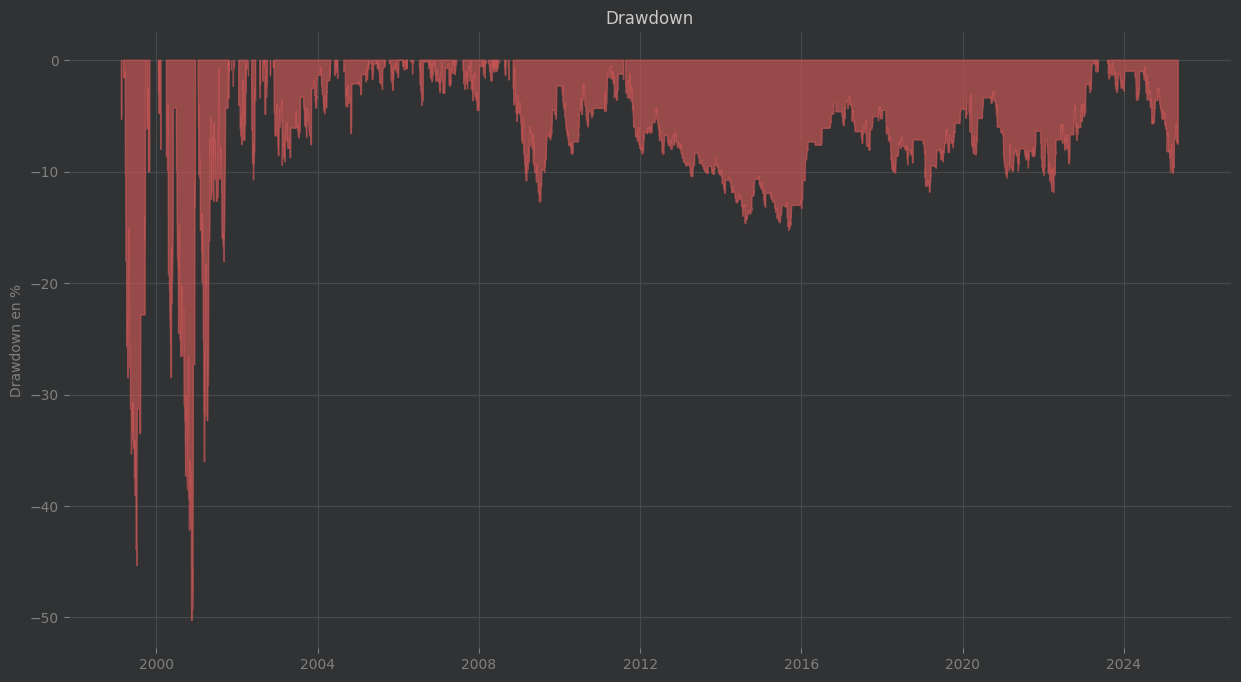

In [11]:
#  tamaño de la figura
plt.figure(figsize=(15,8))

# Representar el drawdown
plt.fill_between(drawdown.index, drawdown*100, 0,
                 drawdown, color="#CE5757", alpha=0.65)

# Añadimos el título
plt.title("Drawdown")

# Etiqueta del eje de la y
plt.ylabel("Drawdown en %")

plt.show()

In [12]:
# Cálculo del drawdown máximo
max_drawdown = -np.min(drawdown)*100
print(f"Max drawdown: {'%.1f' % max_drawdown} %")

Max drawdown: 50.3 %


# *3: Función BackTest para evaluar la estrategia *

In [20]:
def BackTest(serie, annualized_scalar=252):
    import matplotlib.pyplot as plt
    import yfinance as yf
    import numpy as np
    import pandas as pd

    # Validar y renombrar la serie
    if not isinstance(serie, pd.Series):
        raise TypeError("⚠️ 'serie' debe ser un pandas.Series con índice de fechas.")
    serie = serie.copy()
    serie.name = "return"

    # Descargar el benchmark SP500
    try:
        sp500 = yf.download("^GSPC", auto_adjust=False)["Adj Close"].pct_change()
        sp500.name = "SP500"
    except Exception as e:
        raise RuntimeError(f"❌ Error descargando SP500: {e}")

    # Combinar las series y asegurarse de que se alineen
    val = pd.concat([serie, sp500], axis=1).dropna()

    if "return" not in val.columns or "SP500" not in val.columns:
        raise KeyError("❌ No se encuentran las columnas 'return' y 'SP500' después de concatenar.")

    # --------------------
    # Calcular drawdown
    def drawdown_function(r):
        wealth = (1 + r).cumprod()
        peak = wealth.cummax()
        drawdown = (wealth - peak) / peak
        return drawdown

    drawdown = drawdown_function(val["return"]) * 100
    max_drawdown = -np.min(drawdown)

    # --------------------
    # Plot
    fig, (cum, dra) = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle("Backtesting", size=20)

    cum.plot(val["return"].cumsum() * 100, color="#39B3C7", label="Portfolio", ax=cum)
    cum.plot(val["SP500"].cumsum() * 100, color="#B85A0F", label="SP500", ax=cum)
    cum.set_title("Cumulative Return")
    cum.set_ylabel("Cumulative Return (%)")
    cum.legend()

    dra.fill_between(drawdown.index, 0, drawdown, color="#C73954", alpha=0.65)
    dra.set_title("Drawdown")
    dra.set_ylabel("Drawdown (%)")

    plt.tight_layout()
    plt.show()

    # --------------------
    # Métricas
    mean_ret = val["return"].mean()
    downside_std = val["return"][val["return"] < 0].std()
    sortino = np.sqrt(annualized_scalar) * mean_ret / downside_std

    cov_matrix = np.cov(val["return"], val["SP500"])
    beta = cov_matrix[0, 1] / np.var(val["SP500"])
    alpha = annualized_scalar * (mean_ret - beta * val["SP500"].mean())

    # --------------------
    # Resultados
    print(f"📊 Resultados del Backtest")
    print(f"----------------------------")
    print(f"✅ Sortino Ratio     : {np.round(sortino, 3)}")
    print(f"📉 Max Drawdown      : {np.round(max_drawdown, 2)} %")
    print(f"📈 Beta              : {np.round(beta, 3)}")
    print(f"💡 Alpha anualizado  : {np.round(alpha * 100, 3)} %")
